This notebook evaluates the predictions for GRF curves, contact classification, and GRF distribution.

#  Input parameters here

In [1]:
# # PARAMETERS # #
BASE_DIR = '/content/drive/My Drive/CS230_FinalReport/' # your base directory
MASK_VALUE = 999.
MAX_TIMESTEPS = 112
EXP_TYPE = 'with_physicsinputs'
USE_TRANSFORMED = False
# # # # # # # # # #

# Load libraries and data

In [2]:
# Mount Drive to access data.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

In [4]:
# Load in predictions and true labels
if USE_TRANSFORMED:
  Y_true = np.load(file=os.path.join(BASE_DIR, 'models', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'Y_true_cont_transformed.npy'), allow_pickle = True)
else:
  Y_true = np.load(file=os.path.join(BASE_DIR, 'data', 'processed', 'normalized', 'with_physicsinputs', 'Y_test_norm_100Hz_RawDist.npy'), allow_pickle = True) # same for with and without

Y_true_cont  = Y_true[:,:,0:20]
Y_true_class = Y_true[:,:,20:22]
Y_true_dist  = Y_true[:,:,22:]

if USE_TRANSFORMED:
  Y_pred_cont = np.load(file=os.path.join(BASE_DIR, 'models', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'Y_pred_cont_transformed.npy'), allow_pickle = True)
else:
  Y_pred_cont = np.load(file = os.path.join(BASE_DIR, 'models', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'testset_predictions_cont.npy'), allow_pickle = True)

Y_pred_class = np.load(file = os.path.join(BASE_DIR, 'models', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'testset_predictions_class.npy'), allow_pickle = True)
Y_pred_dist  = np.load(file = os.path.join(BASE_DIR, 'models', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'testset_predictions_dist.npy'), allow_pickle = True)

In [5]:
# Load training set means and stds
Y_train_means = np.load(file = os.path.join(BASE_DIR, 'data', 'processed', 'normalized', EXP_TYPE, 'Y_train_means_100Hz_RawDist.npy'), allow_pickle = True)
Y_train_stds = np.load(file = os.path.join(BASE_DIR, 'data', 'processed', 'normalized', EXP_TYPE, 'Y_train_stds_100Hz_RawDist.npy'), allow_pickle = True)

# GRF (F/m) predictions: right, left, and total

## Functions for analysis

In [6]:
def analyze_oagr(Y_pred_oagr, Y_true_oagr, Y_train_means, Y_train_stds, num_subjs, num_trials, data_type, loss_type, plot_savedir, USE_TRANSFORMED, MASK_VALUE=999):
    """
    Plots and calculates error metrics.
    """
    # Store output names.
    out_node_names = ['R GRF mag','R GRF x','R GRF y','R GRF z',
                      'L GRF mag','L GRF x','L GRF y','L GRF z',
                      'R GRM mag','R GRM x','R GRM y','R GRM z',
                      'L GRM mag','L GRM x','L GRM y','L GRM z',
                      'Tot GRF mag', 'Tot GRF x', 'Tot GRF y', 'Tot GRF z']

    # Init arrays to store error metrics.
    rmses = np.zeros((num_subjs,20))
    corrs = np.zeros((num_subjs,20))

    # loop over 7 test subjects, and get all steps per subj
    for s in range(num_subjs):

        Y_pred_allfeats = Y_pred_oagr[num_trials*s:num_trials*(s+1), :, :] # shape = 100 x 168 x 20
        Y_true_allfeats = Y_true_oagr[num_trials*s:num_trials*(s+1), :, :]

        # Identify the minimum where masking/padding started for the given subject over all trials for given task.
        min_timestep = np.min(np.nonzero(Y_true_allfeats == MASK_VALUE)[1])

        # Create subplots for all the outputs for each subject.
        for plots in range(2):
          fig, axs = plt.subplots(5, 4, figsize=(20,20))
          fig.suptitle(f"{data_type}{loss_type}: OAGR Subject {s}")

          for f in range(20): # loop over all features

              # Subset Y_pred and Y_true based on min timesteps and given feature.
              Y_pred = Y_pred_allfeats[:,0:min_timestep,f] # shape = 100, unmasked time range, 1 feature
              Y_true = Y_true_allfeats[:,0:min_timestep,f]

              # Reverse normalize based on which dataset training means and stds.
              if not USE_TRANSFORMED:
                Y_pred = (Y_pred*Y_train_stds.T[f] + Y_train_means.T[f])
                Y_true = (Y_true*Y_train_stds.T[f] + Y_train_means.T[f])

              if plots == 0: # only calc once
                # # ERROR METRICS # #
                # Calculate RMSE for each feature.
                rmses[s,f] = sqrt(mean_squared_error(Y_true.ravel(), Y_pred.ravel()))

                # Calculate corr for each feature.
                r = np.corrcoef(Y_true.ravel(), Y_pred.ravel())
                corr = r[0,1]
                if np.isnan(corr):
                    corrs[s,f] = 0
                else:
                    corrs[s,f] = corr

              # # PLOTTING # #
              # Add to subplots (vs. timesteps plot):
              if f < 4: row = 0
              elif f < 8: row = 1
              elif f < 12: row = 2
              elif f < 16: row = 3
              else: row = 4

              Y_pred_mean = np.mean(Y_pred,axis=0)
              Y_pred_std = np.std(Y_pred,axis=0)
              Y_true_mean = np.mean(Y_true,axis=0)
              Y_true_std = np.std(Y_true,axis=0)

              if plots == 0:
                axs[row, f%4].plot(Y_pred_mean,'r',label='prediction')
                axs[row, f%4].fill_between(range(len(Y_pred_mean)), Y_pred_mean-Y_pred_std, Y_pred_mean+Y_pred_std,
                                          alpha=0.5, edgecolor='r', facecolor='r', linewidth=0)
                axs[row, f%4].plot(Y_true_mean,'b',label='true')
                axs[row, f%4].fill_between(range(len(Y_true_mean)), Y_true_mean-Y_true_std, Y_true_mean+Y_true_std,
                                          alpha=0.5, edgecolor='b', facecolor='b', linewidth=0)

                axs[row, f%4].set_title(out_node_names[f])
                if f == 0:
                  axs[row, f%4].legend()
                if row == 4:
                  axs[row, f%4].set_xlabel('timesteps')
                if (row == 0 or row == 1) and f%4 == 0:
                  axs[row, f%4].set_ylabel('BW')
                if (row == 2 or row == 3) and f%4 == 0:
                  axs[row, f%4].set_ylabel('BW*Ht')
                if (row == 4) and f%4 == 0:
                  axs[row, f%4].set_ylabel('BW')

              else:
                axs[row, f%4].scatter(Y_true_mean, Y_pred_mean)
                axs[row, f%4].set_title(out_node_names[f])
                min_value = min(min(Y_true_mean), min(Y_pred_mean))
                max_value = max(max(Y_true_mean), max(Y_pred_mean))
                axs[row, f%4].set_xlim([min_value, max_value])
                axs[row, f%4].set_ylim([min_value, max_value])
                if f == 16:
                  axs[row, f%4].set_xlabel('true')
                  axs[row, f%4].set_ylabel('predicted')

          # Save figure for each subject.
          if not USE_TRANSFORMED:
            if plots == 0: figname = 'oagr_subj' + str(s) + '.png'
            else: figname = 'oagr_subj' + str(s) + 'predvstrue.png'
          else:
            if plots == 0: figname = 'oagr_subj' + str(s) + '_transformed.png'
            else: figname = 'oagr_subj' + str(s) + 'predvstrue_transformed.png'
          plt.savefig(os.path.join(plot_savedir, figname))

    return rmses, corrs

In [7]:
def analyze_acl(Y_pred_acl, Y_true_acl, Y_train_means, Y_train_stds, num_subjs, num_trials, data_type, loss_type, plot_savedir, USE_TRANSFORMED, MASK_VALUE=999):
    """
    Plots and calculates error metrics.
    """
    # Store output names.
    out_node_names = ['R GRF mag','R GRF x','R GRF y','R GRF z',
                      'L GRF mag','L GRF x','L GRF y','L GRF z',
                      'R GRM mag','R GRM x','R GRM y','R GRM z',
                      'L GRM mag','L GRM x','L GRM y','L GRM z',
                      'Tot GRF mag', 'Tot GRF x', 'Tot GRF y', 'Tot GRF z']

    acl_tasks = ['_cutting','_dj','_lldj','_rldj','_unant_cut']

    # Init arrays to store error metrics.
    rmses = np.zeros((num_subjs*5,20)) # 5 tasks
    corrs = np.zeros((num_subjs*5,20)) # 5 tasks
    metric_counter = 0

    # loop over test subjects, and get all steps per subj
    for s in range(num_subjs):

        # Subset data by subject
        Y_pred_allsubjtasks = Y_pred_acl[num_trials*5*s:num_trials*5*(s+1), :, :] # shape = 15 x 168 x 20
        Y_true_allsubjtasks = Y_true_acl[num_trials*5*s:num_trials*5*(s+1), :, :]

        for task in range(5): # 5 tasks

            # Subset data by task.
            Y_pred_allfeats = Y_pred_allsubjtasks[num_trials*task:num_trials*(task+1),:,:] #  shape = 3 x 168 x 16
            Y_true_allfeats = Y_true_allsubjtasks[num_trials*task:num_trials*(task+1),:,:]

            # Identify the minimum where masking/padding started for the given subject over all trials for given task.
            min_timestep = np.min(np.nonzero(Y_true_allfeats == MASK_VALUE)[1])

            for plots in range(2):
              # Create subplots for all the outputs for each subject and task.
              fig, axs = plt.subplots(5, 4, figsize=(20,20))
              fig.suptitle(f"{data_type}{loss_type}: ACL Subject {s}, {acl_tasks[task]}")

              for f in range(20): # loop over all features

                # Subset Y_pred and Y_true based on min timesteps and given feature.
                Y_pred = Y_pred_allfeats[:,0:min_timestep,f] # shape = 3, unmasked time range, 1 feature
                Y_true = Y_true_allfeats[:,0:min_timestep,f]

                # Reverse normalize based on which dataset training means and stds.
                if not USE_TRANSFORMED:
                  Y_pred = (Y_pred*Y_train_stds.T[f] + Y_train_means.T[f])
                  Y_true = (Y_true*Y_train_stds.T[f] + Y_train_means.T[f])

                if plots == 0: # only calc once
                  # # ERROR METRICS # #
                  # Calculate RMSE for each feature.
                  rmses[metric_counter,f] = sqrt(mean_squared_error(Y_true.ravel(), Y_pred.ravel()))

                  # Calculate corr for each feature.
                  r = np.corrcoef(Y_true.ravel(), Y_pred.ravel())
                  corr = r[0,1]
                  if np.isnan(corr):
                      corrs[metric_counter,f] = 0
                  else:
                      corrs[metric_counter,f] = corr

                # # PLOTTING # #
                # Add to subplots:
                if f < 4: row = 0
                elif f < 8: row = 1
                elif f < 12: row = 2
                elif f < 16: row = 3
                else: row = 4

                Y_pred_mean = np.mean(Y_pred,axis=0)
                Y_pred_std = np.std(Y_pred,axis=0)
                Y_true_mean = np.mean(Y_true,axis=0)
                Y_true_std = np.std(Y_true,axis=0)

                if plots == 0:

                  axs[row, f%4].plot(Y_pred_mean,'r',label='prediction')
                  axs[row, f%4].fill_between(range(len(Y_pred_mean)), Y_pred_mean-Y_pred_std, Y_pred_mean+Y_pred_std,
                                            alpha=0.5, edgecolor='r', facecolor='r', linewidth=0)
                  axs[row, f%4].plot(Y_true_mean,'b',label='true')
                  axs[row, f%4].fill_between(range(len(Y_true_mean)), Y_true_mean-Y_true_std, Y_true_mean+Y_true_std,
                                            alpha=0.5, edgecolor='b', facecolor='b', linewidth=0)

                  axs[row, f%4].set_title(out_node_names[f])
                  if f == 0:
                    axs[row, f%4].legend()
                  if row == 4:
                    axs[row, f%4].set_xlabel('timesteps')
                  if (row == 0 or row == 1) and f%4 == 0:
                    axs[row, f%4].set_ylabel('BW')
                  if (row == 2 or row == 3) and f%4 == 0:
                    axs[row, f%4].set_ylabel('BW*Ht')
                  if (row == 4) and f%4 == 0:
                    axs[row, f%4].set_ylabel('BW')

                else:
                  axs[row, f%4].scatter(Y_true_mean, Y_pred_mean)
                  axs[row, f%4].set_title(out_node_names[f])
                  min_value = min(min(Y_true_mean), min(Y_pred_mean))
                  max_value = max(max(Y_true_mean), max(Y_pred_mean))
                  axs[row, f%4].set_xlim([min_value, max_value])
                  axs[row, f%4].set_ylim([min_value, max_value])
                  if f == 16:
                    axs[row, f%4].set_xlabel('true')
                    axs[row, f%4].set_ylabel('predicted')

              # Save figure for each subject and task.
              if not USE_TRANSFORMED:
                if plots == 0: figname = 'acl_subj' + str(s) + acl_tasks[task] + '.png'
                else: figname = 'acl_subj' + str(s) + acl_tasks[task] + '_predvstrue.png'
              else:
                if plots == 0: figname = 'acl_subj' + str(s) + acl_tasks[task] + '_transformed.png'
                else: figname = 'acl_subj' + str(s) + acl_tasks[task] + '_predvstrue_transformed.png'
              plt.savefig(os.path.join(plot_savedir, figname))

            metric_counter += 1

    return rmses, corrs

## Process

In [9]:
plot_savedir = os.path.join(BASE_DIR, 'reports','figures', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly')

rmses_oagr, corr_oagr = analyze_oagr(Y_pred_oagr = Y_pred_cont[0:700,:,:], Y_true_oagr = Y_true_cont[0:700,:,:], Y_train_means = Y_train_means, Y_train_stds = Y_train_stds, num_subjs = 7, num_trials = 100, data_type = EXP_TYPE, loss_type = 'MSE loss', plot_savedir = plot_savedir, USE_TRANSFORMED = False, MASK_VALUE=MASK_VALUE)
rmses_acl, corr_acl   = analyze_acl(Y_pred_acl = Y_pred_cont[700:,:,:], Y_true_acl = Y_true_cont[700:,:,:], Y_train_means = Y_train_means, Y_train_stds = Y_train_stds, num_subjs = 7, num_trials = 3, data_type = EXP_TYPE, loss_type = 'MSE loss', plot_savedir = plot_savedir, USE_TRANSFORMED = False, MASK_VALUE=MASK_VALUE)

Output hidden; open in https://colab.research.google.com to view.

In [10]:
# Print error metrics to file
if not USE_TRANSFORMED:
  pd.DataFrame(rmses_oagr).to_excel(os.path.join(BASE_DIR, 'reports', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'rmses_oagr.xlsx'))
  pd.DataFrame(corr_oagr).to_excel(os.path.join(BASE_DIR, 'reports', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'corr_oagr.xlsx'))
  pd.DataFrame(rmses_acl).to_excel(os.path.join(BASE_DIR, 'reports', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'rmses_acl.xlsx'))
  pd.DataFrame(corr_acl).to_excel(os.path.join(BASE_DIR, 'reports', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'corr_acl.xlsx'))
else:
  pd.DataFrame(rmses_oagr).to_excel(os.path.join(BASE_DIR, 'reports', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'rmses_oagr_transformed.xlsx'))
  pd.DataFrame(corr_oagr).to_excel(os.path.join(BASE_DIR, 'reports', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'corr_oagr_transformed.xlsx'))
  pd.DataFrame(rmses_acl).to_excel(os.path.join(BASE_DIR, 'reports', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'rmses_acl_transformed.xlsx'))
  pd.DataFrame(corr_acl).to_excel(os.path.join(BASE_DIR, 'reports', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'corr_acl_transformed.xlsx'))

# Contact classification predictions

In [11]:
# Store all accuracies in a table
all_accs = np.zeros(shape=(7,2))

# Check overall accuracies
num_trials = Y_pred_class.shape[0]
R_accuracies = np.zeros(num_trials)
L_accuracies = np.zeros(num_trials)

for trial in range(num_trials):
  curr_pred = Y_pred_class[trial,:,:]
  curr_true = Y_true_class[trial,:,:]

  # Get min time step
  if MASK_VALUE in curr_true:
    min_timestep = np.min(np.nonzero(curr_true[:,0] == MASK_VALUE))
  else:
    min_timestep = MAX_TIMESTEPS

  # Get non-masked values
  curr_pred = curr_pred[0:min_timestep,:]
  curr_true = curr_true[0:min_timestep,:]

  # Get predicted labels based on probabilities
  curr_pred = np.where(curr_pred >= 0.5, 1, 0)

  # Calc and store accuracies
  R_accuracies[trial] = np.sum(curr_pred[:,0] == curr_true[:,0]) / min_timestep
  L_accuracies[trial] = np.sum(curr_pred[:,1] == curr_true[:,1]) / min_timestep

# Get average accuracies
print(f"average right leg step classification accuracy: {np.mean(R_accuracies)}")
print(f"average left leg step classification accuracy: {np.mean(L_accuracies)}")
all_accs[0,0] = np.mean(R_accuracies)
all_accs[0,1] = np.mean(L_accuracies)

average right leg step classification accuracy: 0.9952790408829705
average left leg step classification accuracy: 0.9804626857956761


In [12]:
# to check 100% accuracies....
Y_true_class_unmasked = Y_true_class[Y_true_class != MASK_VALUE]
Y_pred_class_unmasked = Y_pred_class[Y_true_class != MASK_VALUE]
Y_pred_class_unmasked = np.where(Y_pred_class_unmasked >= 0.5, 1, 0)
if sum(Y_true_class_unmasked == Y_pred_class_unmasked) == Y_true_class_unmasked.shape[0]:
  print("all true matches preds")

In [13]:
# Compute per task accuracies
Y_pred_oagr = Y_pred_class[0:700,:,:]
Y_true_oagr = Y_true_class[0:700,:,:]
Y_pred_acl  = Y_pred_class[700:805,:,:]
Y_true_acl  = Y_true_class[700:805,:,:]

# OAGR: we can just loop over all trials as usual since all walking
num_trials = Y_pred_oagr.shape[0]
R_accuracies = np.zeros(num_trials)
L_accuracies = np.zeros(num_trials)

for trial in range(num_trials):
  curr_pred = Y_pred_oagr[trial,:,:]
  curr_true = Y_true_oagr[trial,:,:]

  # Get min time step
  if MASK_VALUE in curr_true:
    min_timestep = np.min(np.nonzero(curr_true[:,0] == MASK_VALUE))
  else:
    min_timestep = MAX_TIMESTEPS

  # Get non-masked values
  curr_pred = curr_pred[0:min_timestep,:]
  curr_true = curr_true[0:min_timestep,:]

  # Get predicted labels based on probabilities
  curr_pred = np.where(curr_pred >= 0.5, 1, 0)

  # Calc and store accuracies
  R_accuracies[trial] = np.sum(curr_pred[:,0] == curr_true[:,0]) / min_timestep
  L_accuracies[trial] = np.sum(curr_pred[:,1] == curr_true[:,1]) / min_timestep

# Get average accuracies
print(f"average right leg step classification accuracy for all walking trials: {np.mean(R_accuracies)}")
print(f"average left leg step classification accuracy for all walking trials: {np.mean(L_accuracies)}")
all_accs[1,0] = np.mean(R_accuracies)
all_accs[1,1] = np.mean(L_accuracies)

# ACL: reshape to get per task accuracies
num_trials = 7 * 3 # num trials per task
R_accuracies = np.zeros(shape=(5, num_trials)) # 5 tasks x num trials per task
L_accuracies = np.zeros(shape=(5, num_trials))

# Reshape
Y_pred_acl_reshaped = np.reshape(Y_pred_acl, (7,5,3,Y_pred_acl.shape[1], Y_pred_acl.shape[2])) # subjs x tasks x trials x timesteps x outputs
Y_true_acl_reshaped = np.reshape(Y_true_acl, (7,5,3,Y_true_acl.shape[1], Y_true_acl.shape[2]))

for task in range(5):
  task_pred = Y_pred_acl_reshaped[:,task,:,:,:]
  task_true = Y_true_acl_reshaped[:,task,:,:,:]

  for trial in range(num_trials):
    curr_pred = np.reshape(task_pred, (num_trials, MAX_TIMESTEPS, 2))
    curr_true = np.reshape(task_true, (num_trials, MAX_TIMESTEPS, 2))
    curr_pred = curr_pred[trial,:,:]
    curr_true = curr_true[trial,:,:]

    # Get min time step
    if MASK_VALUE in curr_true:
      min_timestep = np.min(np.nonzero(curr_true[:,0] == MASK_VALUE))
    else:
      min_timestep = MAX_TIMESTEPS

    # Get non-masked values
    curr_pred = curr_pred[0:min_timestep,:]
    curr_true = curr_true[0:min_timestep,:]

    # Get predicted labels based on probabilities
    curr_pred = np.where(curr_pred >= 0.5, 1, 0)

    # Calc and store accuracies
    R_accuracies[task, trial] = np.sum(curr_pred[:,0] == curr_true[:,0]) / min_timestep
    L_accuracies[task, trial] = np.sum(curr_pred[:,1] == curr_true[:,1]) / min_timestep

    # debugging
    #if task == 2:
      #print(f"R: {R_accuracies[task, trial] }")
      #print(f"L: {L_accuracies[task, trial] }")

# Get average accuracies
tasks = ['cutting','dj','lldj','rldj','unant_cut']
for task in range(5):
  print(f"average right leg step classification accuracy for all {tasks[task]} trials: {np.mean(R_accuracies[task, :])}")
  print(f"average left leg step classification accuracy for all {tasks[task]} trials: {np.mean(L_accuracies[task, :])}")
  all_accs[task+2, 0] = np.mean(R_accuracies[task, :])
  all_accs[task+2, 1] = np.mean(L_accuracies[task, :])

average right leg step classification accuracy for all walking trials: 0.9951326302271494
average left leg step classification accuracy for all walking trials: 0.9797943147268138
average right leg step classification accuracy for all cutting trials: 0.9961904761904763
average left leg step classification accuracy for all cutting trials: 0.9701974708378651
average right leg step classification accuracy for all dj trials: 1.0
average left leg step classification accuracy for all dj trials: 0.995122391750906
average right leg step classification accuracy for all lldj trials: 1.0
average left leg step classification accuracy for all lldj trials: 0.9993650793650792
average right leg step classification accuracy for all rldj trials: 1.0
average left leg step classification accuracy for all rldj trials: 0.9993972272453286
average right leg step classification accuracy for all unant_cut trials: 0.9850850834184167
average left leg step classification accuracy for all unant_cut trials: 0.9605102

In [14]:
# Save accuracies to file
pd.DataFrame(all_accs).to_excel(os.path.join(BASE_DIR, 'reports', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'contact_class_accs.xlsx'))

# GRF distribution predictions

## Functions

In [15]:
def analyze_oagr_dist(Y_pred_oagr, Y_true_oagr, Y_train_means, Y_train_stds, num_subjs, num_trials, data_type, loss_type, plot_savedir, MASK_VALUE=999):
    """
    Plots and calculates error metrics.
    """
    # Store output names.
    out_node_names = ['Right x', 'Right y', 'Right z',
                      'Left x', 'Left y', 'Left z']

    # Init arrays to store error metrics.
    rmses = np.zeros((num_subjs,6))
    corrs = np.zeros((num_subjs,6))

    # loop over 7 test subjects, and get all steps per subj
    for s in range(num_subjs):

        Y_pred_allfeats = Y_pred_oagr[num_trials*s:num_trials*(s+1), :, :] # shape = 100 x 168 x 20
        Y_true_allfeats = Y_true_oagr[num_trials*s:num_trials*(s+1), :, :]

        # Identify the minimum where masking/padding started for the given subject over all trials for given task.
        min_timestep = np.min(np.nonzero(Y_true_allfeats == MASK_VALUE)[1])

        # Create subplots for all the outputs for each subject.
        fig, axs = plt.subplots(2, 3, figsize=(10,6))
        fig.suptitle(f"{data_type}{loss_type}: OAGR Subject {s}")

        for f in range(6): # loop over all features

            # Subset Y_pred and Y_true based on min timesteps and given feature.
            Y_pred = Y_pred_allfeats[:,0:min_timestep,f] # shape = 100, unmasked time range, 1 feature
            Y_true = Y_true_allfeats[:,0:min_timestep,f]

            # Reverse normalize based on which dataset training means and stds. --> we didn't normalize these so take out !
            #Y_pred = (Y_pred*Y_train_stds.T[f]) + Y_train_means.T[f]
            #Y_true = (Y_true*Y_train_stds.T[f]) + Y_train_means.T[f]


            # # ERROR METRICS # #
            # Calculate RMSE for each feature.
            rmses[s,f] = sqrt(mean_squared_error(Y_true.ravel(), Y_pred.ravel()))

            # Calculate corr for each feature.
            r = np.corrcoef(Y_true.ravel(), Y_pred.ravel())
            corr = r[0,1]
            if np.isnan(corr):
                corrs[s,f] = 0
            else:
                corrs[s,f] = corr


            # # PLOTTING # #
            # Add to subplots:
            if f < 3: row = 0
            elif f < 6: row = 1

            Y_pred_mean = np.mean(Y_pred,axis=0)
            Y_pred_std = np.std(Y_pred,axis=0)
            Y_true_mean = np.mean(Y_true,axis=0)
            Y_true_std = np.std(Y_true,axis=0)

            axs[row, f%3].plot(Y_pred_mean,'r',label='prediction')
            axs[row, f%3].fill_between(range(len(Y_pred_mean)), Y_pred_mean-Y_pred_std, Y_pred_mean+Y_pred_std,
                                       alpha=0.5, edgecolor='r', facecolor='r', linewidth=0)
            axs[row, f%3].plot(Y_true_mean,'b',label='true')
            axs[row, f%3].fill_between(range(len(Y_true_mean)), Y_true_mean-Y_true_std, Y_true_mean+Y_true_std,
                                       alpha=0.5, edgecolor='b', facecolor='b', linewidth=0)

            axs[row, f%3].set_title(out_node_names[f])
            axs[row, f%3].set_ylim([-0.5,1.5])
            if f == 0:
              axs[row, f%3].legend()
            if row == 1:
              axs[row, f%3].set_xlabel('timesteps')

        # Save figure for each subject.
        figname = 'oagr_subj' + str(s) + '_dist.png'
        plt.savefig(os.path.join(plot_savedir, figname))

    return rmses, corrs

In [16]:
def analyze_acl_dist(Y_pred_acl, Y_true_acl, Y_train_means, Y_train_stds, num_subjs, num_trials, data_type, loss_type, plot_savedir, MASK_VALUE=999):
    """
    Plots and calculates error metrics.
    """
    # Store output names.
    out_node_names = ['Right x', 'Right y', 'Right z',
                      'Left x', 'Left y', 'Left z']

    acl_tasks = ['_cutting','_dj','_lldj','_rldj','_unant_cut']

    # Init arrays to store error metrics.
    rmses = np.zeros((num_subjs*5,6)) # 5 tasks
    corrs = np.zeros((num_subjs*5,6)) # 5 tasks
    metric_counter = 0

    # loop over test subjects, and get all steps per subj
    for s in range(num_subjs):

        # Subset data by subject
        Y_pred_allsubjtasks = Y_pred_acl[num_trials*5*s:num_trials*5*(s+1), :, :] # shape = 15 x 168 x 20
        Y_true_allsubjtasks = Y_true_acl[num_trials*5*s:num_trials*5*(s+1), :, :]

        for task in range(5): # 5 tasks

            # Subset data by task.
            Y_pred_allfeats = Y_pred_allsubjtasks[num_trials*task:num_trials*(task+1),:,:] #  shape = 3 x 168 x 16
            Y_true_allfeats = Y_true_allsubjtasks[num_trials*task:num_trials*(task+1),:,:]


            # Identify the minimum where masking/padding started for the given subject over all trials for given task.
            min_timestep = np.min(np.nonzero(Y_true_allfeats == MASK_VALUE)[1])

            # Create subplots for all the outputs for each subject and task.
            fig, axs = plt.subplots(2, 3, figsize=(10,6))
            fig.suptitle(f"{data_type}{loss_type}: ACL Subject {s}, {acl_tasks[task]}")

            for f in range(6): # loop over all features

                # Subset Y_pred and Y_true based on min timesteps and given feature.
                Y_pred = Y_pred_allfeats[:,0:min_timestep,f] # shape = 3, unmasked time range, 1 feature
                Y_true = Y_true_allfeats[:,0:min_timestep,f]

                # Reverse normalize based on which dataset training means and stds. --> did not normalize !
                #Y_pred = (Y_pred*Y_train_stds.T[f]) + Y_train_means.T[f]
                #Y_true = (Y_true*Y_train_stds.T[f]) + Y_train_means.T[f]

                # # ERROR METRICS # #
                # Calculate RMSE for each feature.
                rmses[metric_counter,f] = sqrt(mean_squared_error(Y_true.ravel(), Y_pred.ravel()))

                # Calculate corr for each feature.
                r = np.corrcoef(Y_true.ravel(), Y_pred.ravel())
                corr = r[0,1]
                if np.isnan(corr):
                    corrs[metric_counter,f] = 0
                else:
                    corrs[metric_counter,f] = corr


                # # PLOTTING # #
                # Add to subplots:
                if f < 3: row = 0
                elif f < 6: row = 1

                Y_pred_mean = np.mean(Y_pred,axis=0)
                Y_pred_std = np.std(Y_pred,axis=0)
                Y_true_mean = np.mean(Y_true,axis=0)
                Y_true_std = np.std(Y_true,axis=0)

                axs[row, f%3].plot(Y_pred_mean,'r',label='prediction')
                axs[row, f%3].fill_between(range(len(Y_pred_mean)), Y_pred_mean-Y_pred_std, Y_pred_mean+Y_pred_std,
                                          alpha=0.5, edgecolor='r', facecolor='r', linewidth=0)
                axs[row, f%3].plot(Y_true_mean,'b',label='true')
                axs[row, f%3].fill_between(range(len(Y_true_mean)), Y_true_mean-Y_true_std, Y_true_mean+Y_true_std,
                                          alpha=0.5, edgecolor='b', facecolor='b', linewidth=0)

                axs[row, f%3].set_title(out_node_names[f])
                axs[row, f%3].set_ylim([-0.5,1.5])
                if f == 0:
                  axs[row, f%3].legend()
                if row == 1:
                  axs[row, f%3].set_xlabel('timesteps')

            # Save figure for each subject and task.
            figname = 'acl_subj' + str(s) + acl_tasks[task] + '_dist.png'
            plt.savefig(os.path.join(plot_savedir, figname))

            metric_counter += 1

    return rmses, corrs

## Process

In [17]:
plot_savedir = os.path.join(BASE_DIR, 'reports','figures', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly')

rmses_oagr_dist, corr_oagr_dist = analyze_oagr_dist(Y_pred_oagr = Y_pred_dist[0:700,:,:], Y_true_oagr = Y_true_dist[0:700,:,:], Y_train_means = Y_train_means[:,22:], Y_train_stds = Y_train_stds[:,22:], num_subjs = 7, num_trials = 100, data_type = EXP_TYPE, loss_type = 'MSE loss', plot_savedir = plot_savedir, MASK_VALUE=MASK_VALUE)
rmses_acl_dist, corr_acl_dist   = analyze_acl_dist(Y_pred_acl = Y_pred_dist[700:,:,:], Y_true_acl = Y_true_dist[700:,:,:], Y_train_means = Y_train_means[:,22:], Y_train_stds = Y_train_stds[:,22:], num_subjs = 7, num_trials = 3, data_type = EXP_TYPE, loss_type = 'MSE loss', plot_savedir = plot_savedir, MASK_VALUE=MASK_VALUE)

Output hidden; open in https://colab.research.google.com to view.

In [18]:
# Print error metrics to file
pd.DataFrame(rmses_oagr_dist).to_excel(os.path.join(BASE_DIR, 'reports', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'rmses_oagr_dist.xlsx'))
pd.DataFrame(corr_oagr_dist).to_excel(os.path.join(BASE_DIR, 'reports', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'corr_oagr_dist.xlsx'))
pd.DataFrame(rmses_acl_dist).to_excel(os.path.join(BASE_DIR, 'reports', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'rmses_acl_dist.xlsx'))
pd.DataFrame(corr_acl_dist).to_excel(os.path.join(BASE_DIR, 'reports', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly', 'corr_acl_dist.xlsx'))

# Plot random trials

In [19]:
def analyze_oagr_rand(trial_num, Y_pred_oagr_cont, Y_true_oagr_cont, Y_pred_oagr_dist, Y_true_oagr_dist, Y_train_means, Y_train_stds, num_subjs, num_trials, data_type, loss_type, plot_savedir, USE_TRANSFORMED, MASK_VALUE=999):
    """
    Plots F/m and distribution predictions for select trials.
    """
    # Store output names.
    out_node_names_cont = ['R GRF mag','R GRF x','R GRF y','R GRF z',
                      'L GRF mag','L GRF x','L GRF y','L GRF z',
                      'R GRM mag','R GRM x','R GRM y','R GRM z',
                      'L GRM mag','L GRM x','L GRM y','L GRM z',
                      'Tot GRF mag', 'Tot GRF x', 'Tot GRF y', 'Tot GRF z']

    # Store output names.
    out_node_names_dist = ['Right x', 'Right y', 'Right z',
                      'Left x', 'Left y', 'Left z']

    # Get data for given trial
    Y_pred_allfeats_cont = Y_pred_oagr_cont[trial_num, :, :] # shape = time steps x 20
    Y_true_allfeats_cont = Y_true_oagr_cont[trial_num, :, :]

    Y_pred_allfeats_dist = Y_pred_oagr_dist[trial_num, :, :] # shape = time steps x 2
    Y_true_allfeats_dist = Y_true_oagr_dist[trial_num, :, :]

    # Identify the minimum where masking/padding started
    min_timestep = np.min(np.nonzero(Y_true_allfeats_cont[:,0] == MASK_VALUE))

    # Subset the data based on min timestep
    Y_pred_allfeats_cont = Y_pred_allfeats_cont[0:min_timestep, :]
    Y_true_allfeats_cont = Y_true_allfeats_cont[0:min_timestep, :]

    Y_pred_allfeats_dist = Y_pred_allfeats_dist[0:min_timestep, :]
    Y_true_allfeats_dist = Y_true_allfeats_dist[0:min_timestep, :]

    # Figure out the subject num based on the trial num
    s = trial_num % num_subjs

    # Create subplots for all the outputs for each subject.
    for plots in range(2):
      fig, axs = plt.subplots(5, 4, figsize=(20,20))
      fig.suptitle(f"{data_type}{loss_type}: OAGR Subject {s}")

      for f in range(20): # loop over all features

          # Subset Y_pred and Y_true based on min timesteps and given feature.
          Y_pred = Y_pred_allfeats_cont[:,f] # shape = time vs curr feat
          Y_true = Y_true_allfeats_cont[:,f]

          # Reverse normalize based on which dataset training means and stds.
          if not USE_TRANSFORMED:
            Y_pred = (Y_pred*Y_train_stds.T[f] + Y_train_means.T[f])
            Y_true = (Y_true*Y_train_stds.T[f] + Y_train_means.T[f])

          # # PLOTTING # #
          # Add to subplots (vs. timesteps plot):
          if f < 4: row = 0
          elif f < 8: row = 1
          elif f < 12: row = 2
          elif f < 16: row = 3
          else: row = 4

          if plots == 0:
            axs[row, f%4].plot(Y_pred,'r',label='prediction')
            axs[row, f%4].plot(Y_true,'b',label='true')

            axs[row, f%4].set_title(out_node_names_cont[f])
            if f == 0:
              axs[row, f%4].legend()
            if row == 4:
              axs[row, f%4].set_xlabel('timesteps')
            if (row == 0 or row == 1) and f%4 == 0:
              axs[row, f%4].set_ylabel('BW')
            if (row == 2 or row == 3) and f%4 == 0:
              axs[row, f%4].set_ylabel('BW*Ht')
            if (row == 4) and f%4 == 0:
              axs[row, f%4].set_ylabel('BW')

          else:
            axs[row, f%4].scatter(Y_true, Y_pred)
            axs[row, f%4].set_title(out_node_names_cont[f])
            min_value = min(min(Y_true), min(Y_pred))
            max_value = max(max(Y_true), max(Y_pred))
            axs[row, f%4].set_xlim([min_value, max_value])
            axs[row, f%4].set_ylim([min_value, max_value])
            if f == 16:
              axs[row, f%4].set_xlabel('true')
              axs[row, f%4].set_ylabel('predicted')

      # Save figure for each subject.
      if not USE_TRANSFORMED:
        if plots == 0: figname = 'oagr_subj' + str(s) + 'trial ' + str(trial_num) + '.png'
        else: figname = 'oagr_subj' + str(s) + 'trial ' + str(trial_num) + 'predvstrue.png'
      else:
        if plots == 0: figname = 'oagr_subj' + str(s) + 'trial ' + str(trial_num) + '_transformed.png'
        else: figname = 'oagr_subj' + str(s) + 'trial ' + str(trial_num) + 'predvstrue_transformed.png'
      plt.savefig(os.path.join(plot_savedir, figname))

NameError: ignored

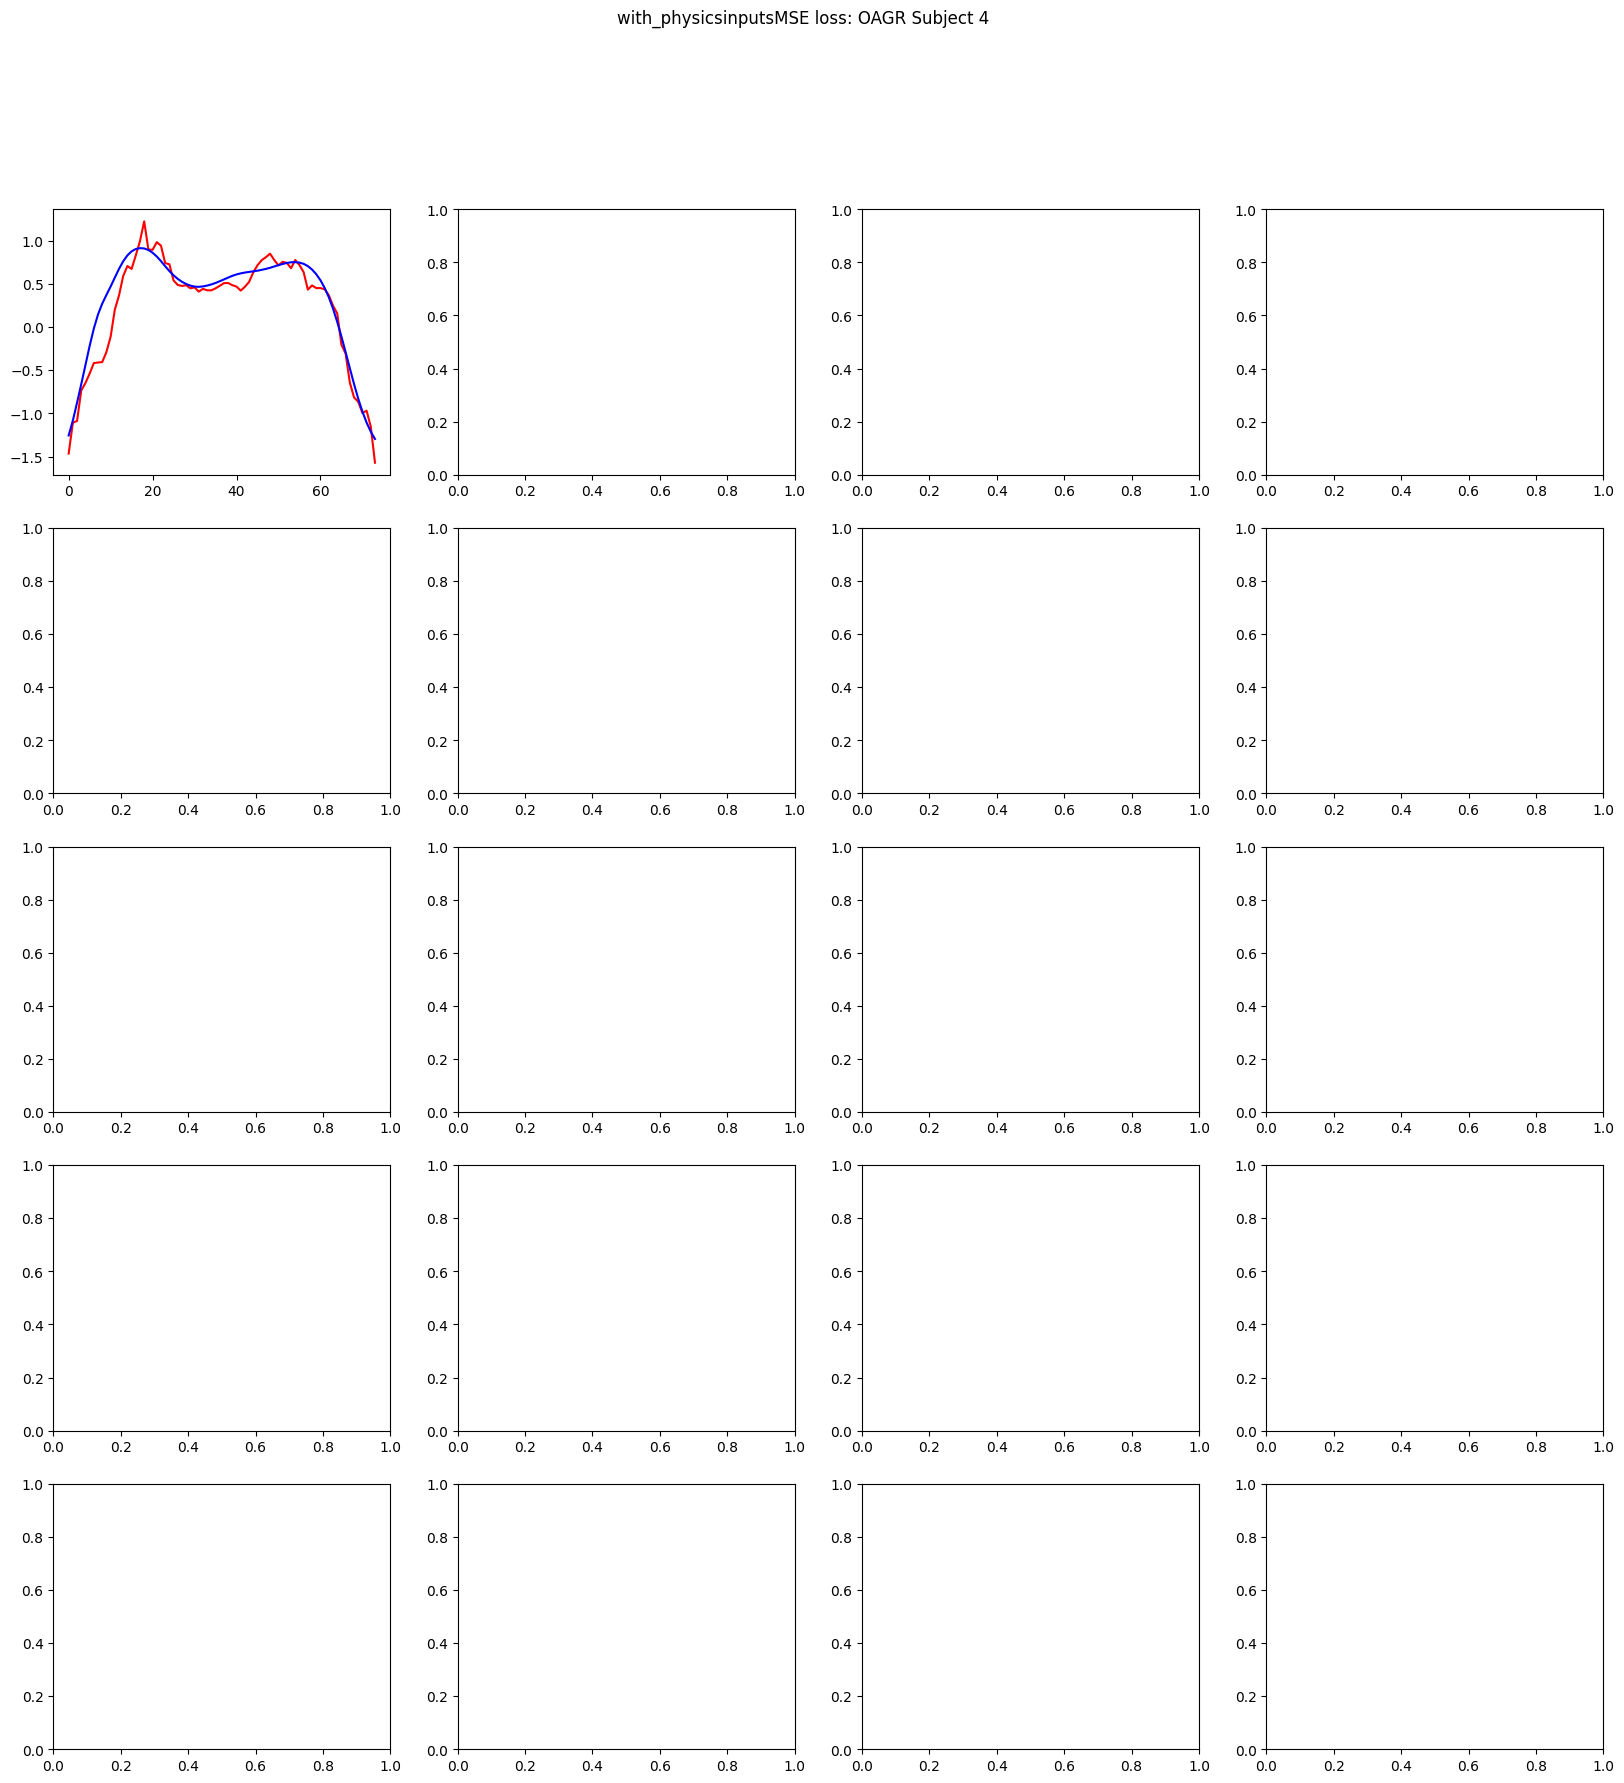

In [20]:
plot_savedir = os.path.join(BASE_DIR, 'reports','figures', EXP_TYPE + '_lstm_newoutputs_transformfix_rawdist_tunedparams_rotonly')



analyze_oagr_rand(123, Y_pred_cont[0:700,:,:], Y_true_cont[0:700,:,:],Y_pred_dist[0:700,:,:], Y_true_dist[0:700,:,:], Y_train_means, Y_train_stds, 7, 100, EXP_TYPE, 'MSE loss', plot_savedir, MASK_VALUE)


# Obsolete
